# Regression Analysis
## Import packages and Data + Data Investigation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [12]:
# read in student math performance data set
#PC
housing = pd.read_csv('data/boston_housing.csv')
housing.isnull().sum()
housing.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [42]:
# split into X and y
y = housing['medv']
X = housing.drop(['medv'], axis=1)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)
[y_train.size, y_test.size]

[404, 102]

## Linear Regression

In [72]:
#do simple linear regression and score against test data
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
y_pred = regressor.predict(X_test)
# score(X_test,y_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', regressor.score(X_test,y_test))

Mean Absolute Error: 3.567326018996795
Mean Squared Error: 26.944812249518147
Root Mean Squared Error: 5.190839262539165
coefficient of determination: 0.6859495577055561


## Boosting
### Adaptive Boosting

In [45]:
#fit many subsets of parametes for adaboost to see which is best subset
scores_ada = []
for learning in [1, 0.5, 0.25, 0.1, 0.05, 0.01]:
    for n in [1, 2, 4, 8, 16, 32, 64, 100, 200]:
        clf_a = AdaBoostRegressor(n_estimators=n, learning_rate=learning, random_state=0)
        scores_a = cross_val_score(clf_a, X_train, y_train.values.ravel(), cv=10)
        score = scores_a.mean()
#         clf_a.fit(X_train, y_train)
#         score = clf_a.score(X_test,y_test)
        scores_ada.append([score, learning, n])

In [75]:
#investigate fits through data and graphs 
scores_ada_df = pd.DataFrame(scores_ada)
scores_ada_df.columns = ['r_sq', 'learn_rate', 'n_estimators']
learn_avg = scores_ada_df.groupby('learn_rate', as_index=False).mean()[['learn_rate','r_sq']]
n_avg = scores_ada_df.groupby('n_estimators', as_index=False).mean()[['n_estimators','r_sq']]
learn_n_avg = scores_ada_df.groupby(['learn_rate','n_estimators'], as_index=False).mean()[['learn_rate','n_estimators','r_sq']]

Text(0.5, 1.0, 'r-squared for Different Learning Rate')

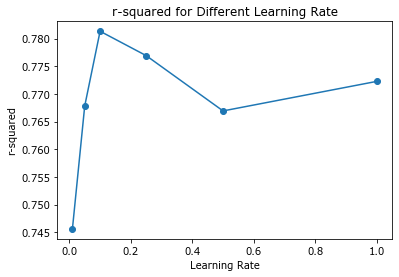

In [73]:
plt.plot(learn_avg.iloc[:,0], learn_avg.iloc[:,1], marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("r-squared")
plt.title("r-squared for Different Learning Rate")

Text(0.5, 1.0, 'r-squared for Different Number of Estimators')

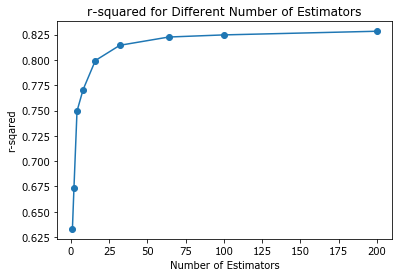

In [70]:
plt.plot(n_avg.iloc[:,0], n_avg.iloc[:,1], marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("r-sqared")
plt.title("r-squared for Different Number of Estimators")

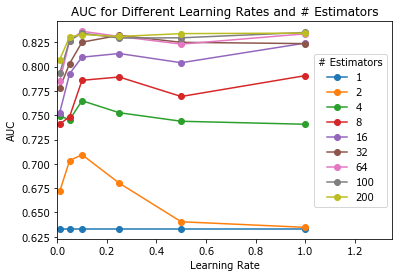

In [76]:
for n in [1, 2, 4, 8, 16, 32, 64, 100, 200]:
    plt_data = learn_n_avg[learn_n_avg['n_estimators'] == n]
    plt.plot(plt_data.iloc[:,0], plt_data.iloc[:,2], marker='o', label=n)
plt.xlim(0,1.35)
plt.legend(loc='right', title = '# Estimators')
plt.xlabel("Learning Rate")
plt.ylabel("AUC")
plt.title("AUC for Different Learning Rates and # Estimators")
plt.show()

In [46]:
#Find parametes for best fit
max_r_sq = scores_ada_df['r_sq'].max()
best_fit = scores_ada_df.loc[scores_ada_df['r_sq'] == max_r_sq]
print(best_fit)

        r_sq  learn_rate  n_estimatores
33  0.836394         0.1             64


In [49]:
#score best fit against test data
clf_a = AdaBoostRegressor(n_estimators=64, learning_rate=.01, random_state=0)
clf_a.fit(X_train, y_train)
score = clf_a.score(X_test,y_test)
score

0.7040134512408971

### Gradient Boosting

In [48]:
#fit different subsets of parameters to find the best subset
scores_grad = []
for depth in [1,2,3,4,5]:
    for learning in [1, 0.5, 0.25, 0.1, 0.05, 0.01]:
        for n in [1, 2, 4, 8, 16, 32, 64, 100, 200]:
            clf_g = GradientBoostingRegressor(n_estimators=n, learning_rate=learning, max_depth=depth, random_state=0)
            scores_g = cross_val_score(clf_g, X_train, y_train.values.ravel(), cv=10)
            score = np.absolute(scores_g).mean()
            scores_grad.append([score,depth, learning, n])
#             clf_g = GradientBoostingRegressor(n_estimators=n, learning_rate=learning, max_depth=depth, random_state=0)
#             clf_g.fit(X_train, y_train)
#             score = clf_g.score(X_test,y_test)
#             scores_grad.append([score,depth, learning, n])

In [77]:
scores_grad_df = pd.DataFrame(scores_grad)
scores_grad_df.columns = ['r_sq','depth', 'learn_rate', 'n_estimators']

depth_avg = scores_grad_df.groupby('depth', as_index=False).mean()[['depth','r_sq']]
learn_avg = scores_grad_df.groupby('learn_rate', as_index=False).mean()[['learn_rate','r_sq']]
n_avg = scores_grad_df.groupby('n_estimators', as_index=False).mean()[['n_estimators','r_sq']]
learn_n_avg = scores_grad_df.groupby(['learn_rate','n_estimators'], as_index=False).mean()[['learn_rate','n_estimators','r_sq']]

In [63]:
#investigate scores through data and graphs 
print(depth_avg)
print(learn_avg)
print(n_avg)

   depth      r_sq
0      1  0.530332
1      2  0.607151
2      3  0.612438
3      4  0.629438
4      5  0.626000
   learn_rate      r_sq
0        0.01  0.290273
1        0.05  0.514363
2        0.10  0.607701
3        0.25  0.719047
4        0.50  0.768507
5        1.00  0.706540
   n_estimatores      r_sq
0              1  0.260727
1              2  0.362127
2              4  0.469077
3              8  0.563972
4             16  0.649315
5             32  0.717374
6             64  0.769367
7            100  0.795672
8            200  0.822014


In [ ]:
for n in [1, 2, 4, 8, 16, 32, 64, 100, 200]:
    plt_data = learn_n_avg[learn_n_avg['n_estimators'] == n]
    plt.plot(plt_data.iloc[:,0], plt_data.iloc[:,2], marker='o', label=n)
plt.xlim(0,1.35)
plt.legend(loc='right', title = '# Estimators')
plt.xlabel("Learning Rate")
plt.ylabel("AUC")
plt.title("AUC for Different Learning Rates and # Estimators")
plt.show()

Text(0.5, 1.0, 'r-squared for Different Tree Depths')

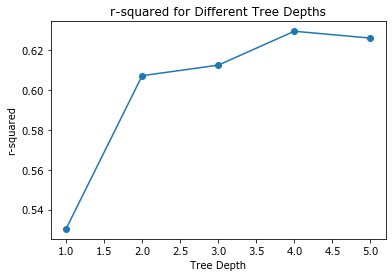

In [64]:
plt.plot(depth_avg.iloc[:,0], depth_avg.iloc[:,1], marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("r-squared")
plt.title("r-squared for Different Tree Depths")

Text(0.5, 1.0, 'r-squared for Different Learning Rate')

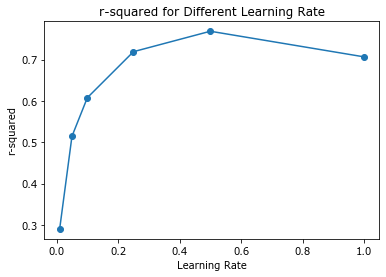

In [61]:
plt.plot(learn_avg.iloc[:,0], learn_avg.iloc[:,1], marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("r-squared")
plt.title("r-squared for Different Learning Rate")

Text(0.5, 1.0, 'r-squared for Different Number of Estimators')

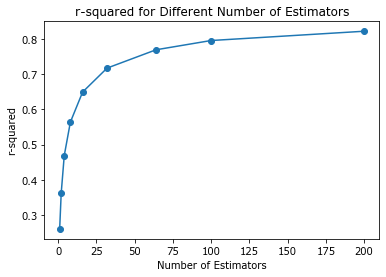

In [67]:
plt.plot(n_avg.iloc[:,0], n_avg.iloc[:,1], marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("r-squared")
plt.title("r-squared for Different Number of Estimators")

In [50]:
# Find parameters for best fit
max_r_sq = scores_grad_df['r_sq'].max()
best_fit = scores_grad_df.loc[scores_grad_df['r_sq'] == max_r_sq]
print(best_fit)

         r_sq  depth  learn_rate  n_estimatores
143  0.886133      3         0.1            200


In [51]:
#Score best model against test data
clf_g = GradientBoostingRegressor(n_estimators=200, learning_rate=.1, max_depth=3, random_state=0)
clf_g.fit(X_train, y_train)
score = clf_g.score(X_test,y_test)
score

0.8125934572759475